<AxesSubplot:>

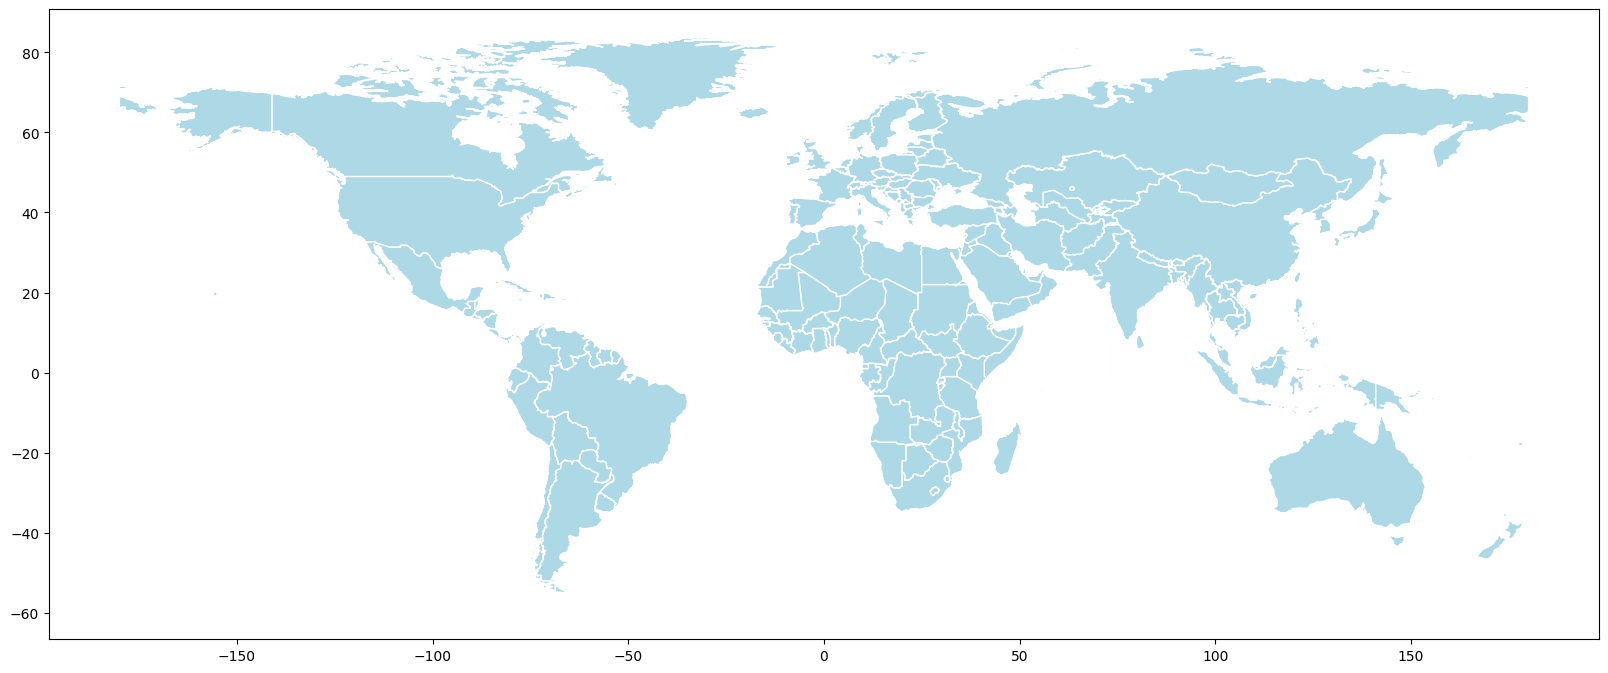

In [173]:

import country_converter as coco
import geopandas as gpd
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt

SHAPEFILE = './worldmap/ne_10m_admin_0_countries.shp'

# Read shapefile using Geopandas
geo_df = gpd.read_file(SHAPEFILE)[['ADMIN', 'ADM0_A3', 'geometry']]

# Rename columns.
geo_df.columns = ['country', 'country_code', 'geometry']

# Drop row for 'Antarctica'. It takes a lot of space in the map and is not of much use
geo_df = geo_df.drop(geo_df.loc[geo_df['country'] == 'Antarctica'].index)

# Print the map
geo_df.plot(figsize=(20, 20), edgecolor='white', linewidth=1, color='lightblue')

In [174]:
# Next, we need to ensure that our data matches with the country codes. 
iso3_codes = geo_df['country'].to_list()

# Convert to iso3_codes
iso2_codes_list = coco.convert(names=iso3_codes, to='ISO2', not_found='NULL')

# Add the list with iso2 codes to the dataframe
geo_df['iso2_code'] = iso2_codes_list

# Drop countries for which the converter could not find a country code. 
geo_df = geo_df.drop(geo_df.loc[geo_df['iso2_code'] == 'NULL'].index)

Dhekelia Sovereign Base Area not found in regex
US Naval Base Guantanamo Bay not found in regex
Siachen Glacier not found in regex
Baykonur Cosmodrome not found in regex
Akrotiri Sovereign Base Area not found in regex
Southern Patagonian Ice Field not found in regex
Bir Tawil not found in regex
Indian Ocean Territories not found in regex
Coral Sea Islands not found in regex
Spratly Islands not found in regex
Clipperton Island not found in regex
Ashmore and Cartier Islands not found in regex
Bajo Nuevo Bank (Petrel Is.) not found in regex
Serranilla Bank not found in regex
Scarborough Reef not found in regex


In [175]:
# import dataset to use for map visualization
cl_real_happiness = pd.read_csv('./data/cl_real_happiness.csv')

# filter by country and then just picked max as min/max/mean all the same
cl_real_happiness = cl_real_happiness.groupby(by='country')['Healthy life expectancy (country)'].max()
cl_real_happiness = cl_real_happiness.reset_index()

# profile geo data to see USA
print(geo_df[geo_df['country'].str.contains('United States')])
print(geo_df.shape)
print(cl_real_happiness.shape)

# Convert USA to US in order to allow for merge
def us_convert(value):
  if value == 'United States of America':
    value = 'United States'
    return value
  else:
    return value

geo_df['country'] = geo_df['country'].map(us_convert)

print(geo_df[geo_df['country'].str.contains('United States')])

                                  country country_code  \
154              United States of America          USA   
204  United States Minor Outlying Islands          UMI   
208          United States Virgin Islands          VIR   

                                              geometry iso2_code  
154  MULTIPOLYGON (((-122.75302 48.99251, -122.6532...        US  
204  MULTIPOLYGON (((-169.53026 16.76020, -169.5208...        UM  
208  MULTIPOLYGON (((-64.55940 17.75161, -64.58519 ...        VI  
(242, 4)
(0, 2)
                                  country country_code  \
154                         United States          USA   
204  United States Minor Outlying Islands          UMI   
208          United States Virgin Islands          VIR   

                                              geometry iso2_code  
154  MULTIPOLYGON (((-122.75302 48.99251, -122.6532...        US  
204  MULTIPOLYGON (((-169.53026 16.76020, -169.5208...        UM  
208  MULTIPOLYGON (((-64.55940 17.75161, -64.5851

In [176]:
cl_real_happiness = cl_real_happiness.append({'country': 'Sudan', 'Healthy life expectancy (country)': 51.0}, ignore_index=True)
cl_real_happiness = cl_real_happiness.append({'country': 'Angola', 'Healthy life expectancy (country)': 50.0}, ignore_index=True)

In [177]:
# functions to convert row strings to enable merging

def congo_convert1(value):
  if value == 'Democratic Republic of the Congo':
    value = 'Congo (Kinshasa)'
    return value
  else:
    return value

def congo_convert2(value):
  if value == 'Republic of the Congo':
    value = 'Congo (Brazzaville)'
    return value
  else:
    return value

def tanzania_convert(value):
  if value == 'United Republic of Tanzania':
    value = 'Tanzania'
    return value
  else:
    return value

geo_df['country'] = geo_df['country'].map(congo_convert1)
geo_df['country'] = geo_df['country'].map(congo_convert2)

print(geo_df[geo_df['country'].str.contains('Congo')])

geo_df['country'] = geo_df['country'].map(tanzania_convert)

print(geo_df[geo_df['country'].str.contains('Tanzania')])
print(geo_df[geo_df['country'].str.contains('Angola')])
print(cl_real_happiness[cl_real_happiness['country'].str.contains('Angola')])

                country country_code  \
30  Congo (Brazzaville)          COG   
31     Congo (Kinshasa)          COD   

                                             geometry iso2_code  
30  POLYGON ((18.62639 3.47687, 18.63455 3.44922, ...        CG  
31  MULTIPOLYGON (((18.62639 3.47687, 18.59300 3.7...        CD  
     country country_code                                           geometry  \
18  Tanzania          TZA  MULTIPOLYGON (((32.92086 -9.40790, 32.90546 -9...   

   iso2_code  
18        TZ  
    country country_code                                           geometry  \
101  Angola          AGO  MULTIPOLYGON (((13.07370 -4.63532, 13.06533 -4...   

    iso2_code  
101        AO  
  country  Healthy life expectancy (country)
1  Angola                               50.0


In [178]:
# Merge the two dataframes
merged_geo_df = pd.merge(left = cl_real_happiness, right = geo_df)

print(merged_geo_df.shape)
print(merged_geo_df.iloc[20:50])

(2, 5)
Empty DataFrame
Columns: [country, Healthy life expectancy (country), country_code, geometry, iso2_code]
Index: []


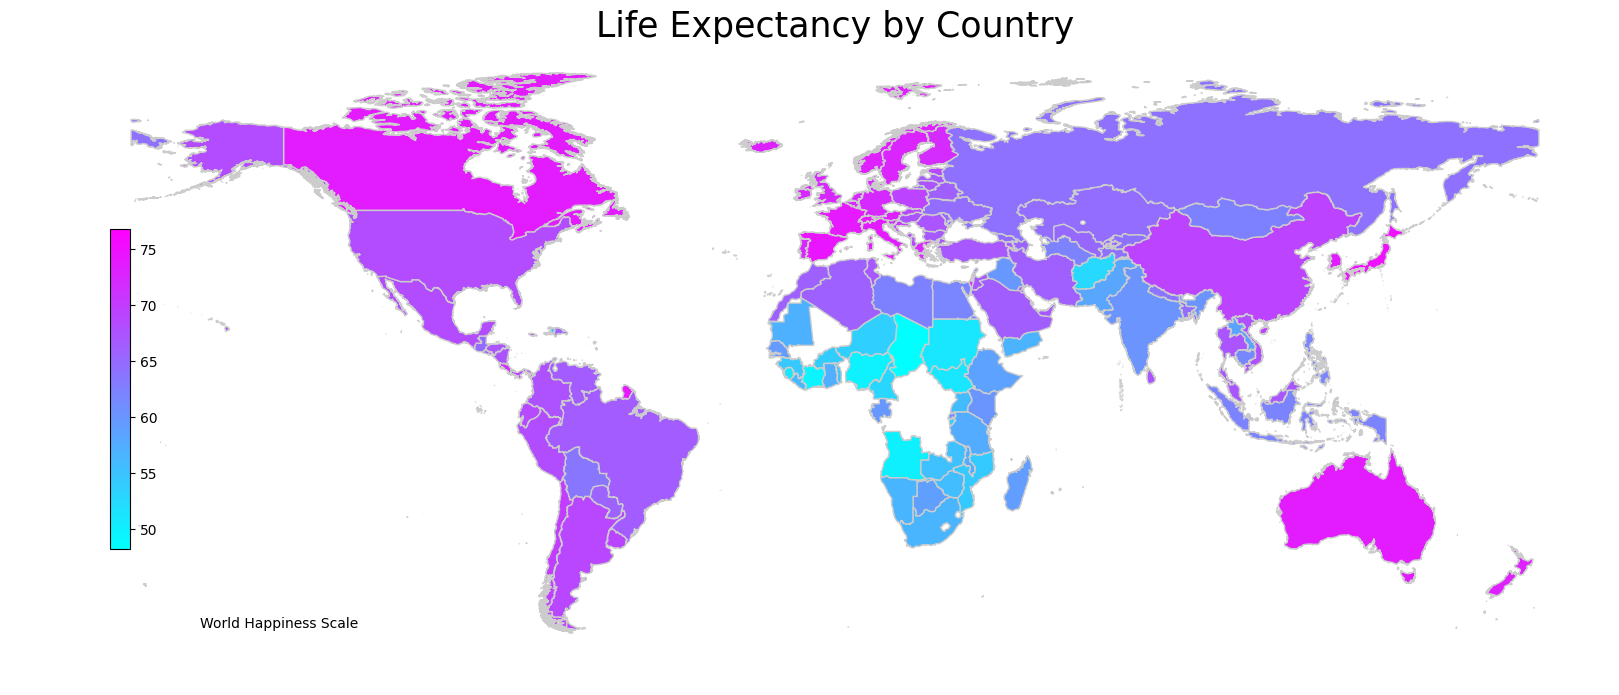

In [172]:
from geopandas import GeoDataFrame
# convert to geodata frame
df = GeoDataFrame(merged_geo_df)

title = 'Life Expectancy by Country'
source = 'World Happiness Scale'
col = 'Healthy life expectancy (country)'
# source = 'Source: relataly.com \nGrowth Rate = New cases / All previous cases'
vmin = df[col].min()
vmax = df[col].max()
cmap = 'cool'

# Create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 8))

# Remove the axis
ax.axis('off')
df.plot(column=col, ax=ax, edgecolor='0.8', linewidth=1, cmap=cmap)

# Add a title
ax.set_title(title, fontdict={'fontsize': '25', 'fontweight': '3'})

# Create an annotation for the data source
ax.annotate(source, xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='bottom', fontsize=10)

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)

# Empty array for the data range
sm._A = []

# Add the colorbar to the figure
cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cbaxes)

In [53]:
title = 'Generosity by Country'
source = 'World Happiness Scale'
col = 'generosity'
# source = 'Source: relataly.com \nGrowth Rate = New cases / All previous cases'
vmin = df[col].min()
vmax = df[col].max()
cmap = 'cool'

# Create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 8))

# Remove the axis
ax.axis('off')
df.plot(column=col, ax=ax, edgecolor='0.8', linewidth=1, cmap=cmap)

# Add a title
ax.set_title(title, fontdict={'fontsize': '25', 'fontweight': '3'})

# Create an annotation for the data source
ax.annotate(source, xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='bottom', fontsize=10)

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)

# Empty array for the data range
sm._A = []

# Add the colorbar to the figure
cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cbaxes)

KeyError: 'generosity'